In [2]:
import pandas as pd
import geopandas as gpd
import random
import csv
from shapely import wkt 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import haversine
%matplotlib inline  

In [3]:
### Survey zones
### S05a_022 is the total automobile trip from that zone

zones_gdf = gpd.read_file(
    'demand_inputs/S05-a-10_SYUTO_GML/S05-a-10_SYUTO-g_Occurred_ConcentratedTrafficVolumeOfPersonTrip.shp')
zones_gdf['urban_area'] = zones_gdf['S05a_001']
zones_gdf['survey_year'] = zones_gdf['S05a_002']
zones_gdf['zone_code'] = zones_gdf['S05a_004']
zones_gdf['total_automobile'] = zones_gdf['S05a_022'].astype(int)
zones_gdf = zones_gdf[['urban_area', 'survey_year', 'zone_code', 'total_automobile', 'geometry']]

zones_gdf = zones_gdf.drop_duplicates(subset='zone_code')
zones_gdf['centroid_x'] = zones_gdf.centroid.x
zones_gdf['centroid_y'] = zones_gdf.centroid.y
print('Numbers of unique zones', len(np.unique(zones_gdf['zone_code'])))
print('Total numbers of auto trips', np.sum(zones_gdf['total_automobile']))
# print(np.unique(zones_gdf['zone_code']))
display(zones_gdf.head(2))

### Plot the survey pdf geometry
# zones_gdf['color'] = np.random.randint(0, 100, zones_gdf.shape[0])
# zones_gdf.plot(column='color', cmap='Spectral')
# plt.show()

Numbers of unique zones 601
Total numbers of auto trips 22909199


urban_area survey_year zone_code  total_automobile  \
0          1        2008      2019              9681   
1          1        2008      0123             18539   

                                            geometry  centroid_x  centroid_y  
0  POLYGON ((139.77108 35.50661, 139.77687 35.505...  139.744443   35.490414  
1  POLYGON ((139.70230 35.62555, 139.70249 35.624...  139.710694   35.611439

In [4]:
### Total demand
survey = pd.read_csv('demand_inputs/d-1.csv', encoding = 'Shift-JIS', header=0, skiprows=3)
# display(survey.nunique())

survey['O_code'] = survey['発ゾーン.1'].apply(lambda x: x.split(':')[1])
survey['D_code'] = survey['着ゾーン.1'].apply(lambda x: x.split(':')[1])
survey['auto_counts'] = survey['自動車'].astype(int)
survey['all_modes'] = survey['計'].astype(int)

def get_suffix(x):
    try: 
        suffix = x.split(':')[2]
    except IndexError: 
        suffix = 'none'
    return suffix

survey['O_code_suffix'] = survey['発ゾーン.1'].apply(lambda x: get_suffix(x))
survey['D_code_suffix'] = survey['着ゾーン.1'].apply(lambda x: get_suffix(x))
print(np.unique(survey['O_code_suffix'])[0:5])
print(np.unique(survey['目的：７分類.1']))

['none' 'さいたま市' 'さいたま市以下不明' 'さいたま市（その他）' '不明']
['不明' '勤務・業務' '帰宅' '私事' '自宅−勤務' '自宅−業務' '自宅−私事' '自宅−通学' '計']


In [5]:
survey = survey.loc[survey['目的：７分類.1']=='計']
survey = survey.loc[survey['O_code'].isin(zones_gdf['zone_code']) & survey['D_code'].isin(zones_gdf['zone_code'])]
survey = survey[['O_code', 'D_code', 'auto_counts', 'all_modes']]
survey = survey.set_index('O_code')
zones_gdf = zones_gdf[['zone_code', 'centroid_x', 'centroid_y', 'geometry']].set_index('zone_code')
survey = survey.join(zones_gdf, how='left')
survey = survey.reset_index().rename(columns={'index': 'O_code'}).set_index('D_code')
survey = survey.join(zones_gdf, how='left', lsuffix='_O', rsuffix='_D')
survey = survey.reset_index().rename(columns={'index': 'D_code'})
zones_gdf = zones_gdf.reset_index().rename(columns={'index': 'zone_code'})
survey['OD_centroid_dist'] = haversine.haversine(survey['centroid_y_O'], survey['centroid_x_O'], survey['centroid_y_D'], survey['centroid_x_D'])
survey = survey[survey['auto_counts']>0]
print('total numbers of auto trips {}, all mode trips {}'.format(np.sum(survey['auto_counts']), np.sum(survey['all_modes'])))
print('total numbers of origin zones {}, destin zones {}, o-d zones {}'.format(len(np.unique(survey['O_code'])), len(np.unique(survey['D_code'])), survey.groupby(['O_code', 'D_code']).size().reset_index().shape[0]))
display(survey.head(2))

total numbers of auto trips 22792317, all mode trips 72119857
total numbers of origin zones 601, destin zones 601, o-d zones 52489


D_code O_code  auto_counts  all_modes  centroid_x_O  centroid_y_O  \
0   0010   0010         2309      44285    139.757044     35.684310   
1   0010   0011         1347       7076    139.741805     35.687237   

                                          geometry_O  centroid_x_D  \
0  POLYGON ((139.75265 35.69345, 139.75320 35.693...    139.757044   
1  POLYGON ((139.75082 35.70233, 139.75079 35.701...    139.757044   

   centroid_y_D                                         geometry_D  \
0      35.68431  POLYGON ((139.75265 35.69345, 139.75320 35.693...   
1      35.68431  POLYGON ((139.75265 35.69345, 139.75320 35.693...   

   OD_centroid_dist  
0          0.000000  
1       1414.323321

20.28251576172563
20.051439832949846


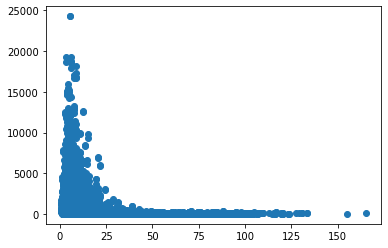

In [5]:
### Test
fig, ax = plt.subplots()
ax.scatter(survey.loc[survey['OD_centroid_dist']>0, 'OD_centroid_dist']/1000, survey.loc[survey['OD_centroid_dist']>0,'auto_counts'])
print(np.mean(survey.loc[survey['OD_centroid_dist']>0, 'OD_centroid_dist']/1000))
print(np.mean(survey['OD_centroid_dist'])/1000)
plt.show()

In [7]:
### Hourly distribution
origin_by_hour = []
for i in range(1, 6):
    subfile = pd.read_csv('demand_inputs/H30_s1/H30_s1_{}.csv'.format(i), encoding = 'Shift-JIS', skiprows=3, header=0)
#     if i== 1: 
#         print(subfile.iloc[0], '\n')
    subfile['file_no'] = i
    subfile['O_code'] = subfile['地域.1'].apply(lambda x: x.split(':')[1][0:4])
    subfile['purpose'] = subfile['目的種類'] ### ??
    subfile['facility'] = subfile['施設'] ### ??
    subfile['hour'] = subfile['時刻']
    subfile['auto_counts'] = subfile['自動車'] ### depart
    subfile['auto_counts_1'] = subfile['自動車.1'] ### arrive
    subfile['auto_counts_2'] = subfile['自動車.2'] ### depart and arrive
    subfile['rail'] = subfile['鉄道']
    subfile['bus'] = subfile['バス']
    subfile['bus_1'] = subfile['バス.1']
    subfile['bus_2'] = subfile['バス.2']
    subfile['motorcycle'] = subfile['２輪車']
    subfile['bike'] = subfile['自転車']
    subfile['walk'] = subfile['徒歩']
    subfile['others'] = subfile['その他']
    subfile['unknown'] = subfile['不明']
    subfile['all_modes'] = subfile['合計']
    subfile['all_modes_1'] = subfile['合計.1']
    subfile['all_modes_2'] = subfile['合計.2']
    origin_by_hour.append(subfile[['file_no', 'O_code', 'purpose', 'facility', 'hour', 'auto_counts', 'auto_counts_1', 'auto_counts_2', 'rail', 'bus', 'bus_1', 'bus_2', 'motorcycle', 'bike', 'walk', 'others', 'unknown', 'all_modes', 'all_modes_1', 'all_modes_2']])
origin_by_hour_df = pd.concat(origin_by_hour, sort=False, ignore_index=True)

origin_by_hour_df = origin_by_hour_df[origin_by_hour_df['O_code'].isin(zones_gdf['zone_code'])]
origin_by_hour_df = origin_by_hour_df[origin_by_hour_df['purpose']==9] ### total trips
origin_by_hour_df = origin_by_hour_df[origin_by_hour_df['hour']<28] ### 28 is the total count
origin_by_hour_df['hour'] = np.where(origin_by_hour_df['hour']<3, origin_by_hour_df['hour']+24, origin_by_hour_df['hour'])
origin_by_hour_df['hour'] = origin_by_hour_df['hour'].apply(lambda x: random.randint(3, 26) if x==27 else x)
origin_by_hour_df = origin_by_hour_df.groupby(['O_code', 'hour']).agg({'auto_counts': np.sum, 'auto_counts_1': np.sum, 'auto_counts_2': np.sum, 'all_modes': np.sum, 'all_modes_1': np.sum, 'all_modes_2': np.sum}).reset_index()
print(len(np.unique(origin_by_hour_df['O_code'])), origin_by_hour_df.shape)

# zones_gdf['color2'] = np.where(zones_gdf['zone_code'].isin(origin_by_hour_df['O_code']), 110,zones_gdf['color'])
# zones_gdf.plot(column='color2', cmap='Spectral')
# plt.show()

592 (13542, 8)


hour                   348
auto_counts       17340421
auto_counts_1     17396691
auto_counts_2     34737112
all_modes         66602953
all_modes_1       66717469
all_modes_2      133320422
dtype: int64


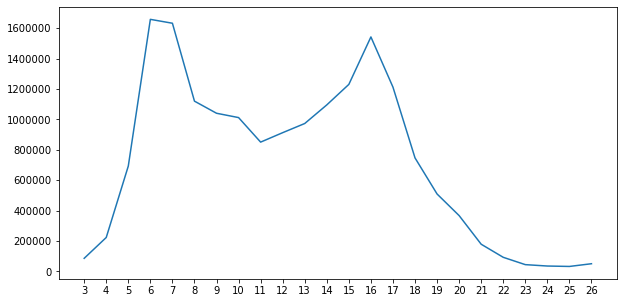

In [8]:
hour_trips = origin_by_hour_df.groupby('hour').agg({
    'auto_counts':np.sum, 
    'auto_counts_1':np.sum, 
    'auto_counts_2':np.sum, 
    'all_modes':np.sum, 
    'all_modes_1':np.sum, 
    'all_modes_2':np.sum}).reset_index()

print(hour_trips.sum())
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hour_trips['hour'], hour_trips['auto_counts'])
ax.set_xticks(range(3, 27))
plt.show()

In [9]:
hour_ratio = origin_by_hour_df[['O_code', 'hour', 'auto_counts']].copy()
hour_ratio['auto_counts_ratio'] = hour_ratio.groupby('O_code')['auto_counts'].transform(lambda x: x/x.sum())
hour_ratio_d = dict()
for hour_ratio_r in hour_ratio.itertuples():
    o_zone = getattr(hour_ratio_r, 'O_code')
    hour = getattr(hour_ratio_r, 'hour')
    auto_ratio = getattr(hour_ratio_r, 'auto_counts_ratio')
    try:
        hour_ratio_d[o_zone][hour] = auto_ratio
    except KeyError:
        hour_ratio_d[o_zone] = dict()
        hour_ratio_d[o_zone][hour] = auto_ratio

avg_ratio = (hour_ratio.groupby('hour')['auto_counts'].sum()/np.sum(hour_ratio['auto_counts'])).to_dict()
    
od_list = []
for zone_od in survey.itertuples():
    zone_o = getattr(zone_od, 'O_code')
    zone_d = getattr(zone_od, 'D_code')
    zone_trip_counts = getattr(zone_od, 'auto_counts')
    if zone_o in hour_ratio_d:
        for hour, ratio in hour_ratio_d[zone_o].items():
            od_list.append([zone_o, zone_d, hour, int(round(zone_trip_counts*ratio))])
    else:
        for hour in range(3, 27):
            od_list.append([zone_o, zone_d, hour, int(round(zone_trip_counts*avg_ratio[hour]))])
zone_hour_od_df = pd.DataFrame(od_list, columns=['O_code', 'D_code', 'hour', 'auto_counts'])
print(np.sum(zone_hour_od_df['auto_counts']))
zone_hour_od_df.to_csv('demand_inputs/zone_hour_od.csv', index=False)

22780349


In [12]:
def nodes_in_zones():
    zones_gdf2 = zones_gdf.drop_duplicates(subset=['zone_code'])
    nodes = pd.read_csv('network_inputs/tokyo_nodes.csv')
    nodes_gdf = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.lon, nodes.lat))
#     nodes_list = []
#     for tile_no in [533935, 533936, 533945, 533946]:
#         nodes_tile = pd.read_csv('../0_network/data/tokyo_sumitomo_shapefiles/adf_nodes_{}.csv'.format(tile_no))
#         nodes_list.append(nodes_tile)
#     nodes_df = pd.concat(nodes_list)
#     nodes_gdf = gpd.GeoDataFrame(nodes_df, crs='epsg:4326', geometry=nodes_df['geometry'].map(wkt.loads))
    nodes_sindex = nodes_gdf.sindex
    nodes_gdf['zone_code'] = ''

    print('start label nodes')
    total_z = 0
    zone_nodes_dict = {}
    for z in zones_gdf2.itertuples():
        ### Based on https://geoffboeing.com/2016/10/r-tree-spatial-index-python/?share=google-plus-1
        possible_match_nodes_index = list(nodes_sindex.intersection(getattr(z, 'geometry').bounds))
        possible_match_nodes = nodes_gdf.iloc[possible_match_nodes_index]
        precise_match_nodes = possible_match_nodes[possible_match_nodes.intersects(getattr(z, 'geometry'))]
        zone_nodes_dict[getattr(z, 'zone_code')] = precise_match_nodes['node_id'].values.tolist()
        
        total_z += 1
        if total_z % 60 == 0: print(getattr(z, 'zone_code'))

    with open('demand_inputs/tokyo_osmnx_nodes_with_zones.json', 'w') as outfile:
        json.dump(zone_nodes_dict, outfile, indent=2)
    return nodes_gdf
    
nodes_gdf = nodes_in_zones()

start label nodes
0033
0720
1114
2014
2812
3215
4041
4434
5214
6092


In [13]:
### Test
zonal_od_df_test = pd.read_csv('demand_inputs/zone_hour_od.csv', dtype={'O_code': str, 'D_code': str})
zonal_od_df_test = pd.merge(zonal_od_df_test, zones_gdf[['zone_code', 'centroid_x', 'centroid_y']], how='left', left_on='O_code', right_on='zone_code')
zonal_od_df_test = zonal_od_df_test.merge(zones_gdf[['zone_code', 'centroid_x', 'centroid_y']], how='left', left_on='D_code', right_on='zone_code', suffixes=['_O', '_D'])
zonal_od_df_test['OD_centroid_dist'] = haversine.haversine(zonal_od_df_test['centroid_y_O'], zonal_od_df_test['centroid_x_O'], zonal_od_df_test['centroid_y_D'], zonal_od_df_test['centroid_x_D'])
print(np.mean(zonal_od_df_test.loc[zonal_od_df_test['OD_centroid_dist']>0, 'OD_centroid_dist']/1000))
print(np.sum(zonal_od_df_test['OD_centroid_dist']*zonal_od_df_test['auto_counts'])/(1000*np.sum(zonal_od_df_test['auto_counts'])))

20.292143983065486
6.170029323947163


In [14]:
### Test
def nodal_OD(nodes_gdf=None):
    ### zonal_od:
    zonal_od_df = pd.read_csv('demand_inputs/zone_hour_od.csv', dtype={'O_code': str, 'D_code': str})
    display(zonal_od_df.head())
    print('total od pairs ', np.sum(zonal_od_df['auto_counts']))
    ### zone_to_osmid
    zone_osmid = json.load(open('demand_inputs/tokyo_osmnx_nodes_with_zones.json'))
    
    node_od_list = []
    unsuccessful_od = []
    for zone_od in zonal_od_df.itertuples():
        zone_o = getattr(zone_od, 'O_code')
        zone_d = getattr(zone_od, 'D_code')
        zone_hour = getattr(zone_od, 'hour')
        zone_hour_trip_counts = getattr(zone_od, 'auto_counts')
        try:
            node_o = random.choices(zone_osmid[zone_o], k=zone_hour_trip_counts)
            node_d = random.choices(zone_osmid[zone_d], k=zone_hour_trip_counts)
            trip_hour = [zone_hour]*zone_hour_trip_counts
            node_od_list += list(zip(node_o, node_d, trip_hour))
        except KeyError:
            unsuccessful_od.append((zone_o, zone_d, zone_hour, zone_hour_trip_counts))
        except IndexError:
            unsuccessful_od.append((zone_o, zone_d, zone_hour, zone_hour_trip_counts))
    random.shuffle(node_od_list)
    print('{} out of {} zonal-hourly OD failed to match to nodes'.format(len(unsuccessful_od), zonal_od_df.shape[0]))
    print('total number of od {}'.format(len(node_od_list)))
        
    def chunks(l, div):
        # Yield successive n-sized chunks from l.
        n = int(np.ceil(len(l)/div))
        for i in range(0, len(l), n):
            yield l[i:i + n]

    div_node_od_super_list = list(chunks(node_od_list, 3))
    chunk_num = 0
    agent_id_shift = 0
    print(nodes_gdf.dtypes)
    for div_node_od_list in div_node_od_super_list:
        div_node_od_df = pd.DataFrame(div_node_od_list, columns=['O', 'D', 'trip_hour'])
        
        div_node_od_df = pd.merge(div_node_od_df, nodes_gdf, how='left', left_on='O', right_on='node_id')
        div_node_od_df = pd.merge(div_node_od_df, nodes_gdf, how='left', left_on='D', right_on='node_id', suffixes={'_O', '_D'})
        div_node_od_df['distance'] = haversine.haversine(
            div_node_od_df['geometry_O'].apply(lambda x: x.y), div_node_od_df['geometry_O'].apply(lambda x: x.x), 
            div_node_od_df['geometry_D'].apply(lambda x: x.y), div_node_od_df['geometry_D'].apply(lambda x: x.x))
        print(np.mean(div_node_od_df.loc[div_node_od_df['distance']>0, 'distance']/1000))
        print(np.mean(div_node_od_df['distance'])/1000)
        
        div_node_od_df['agent_id'] = agent_id_shift
        div_node_od_df['agent_id'] += range(div_node_od_df.shape[0])
        agent_id_shift += div_node_od_df.shape[0]
        div_node_od_df[['agent_id', 'O', 'D', 'trip_hour']].to_csv('demand_inputs/od_{}.csv'.format(chunk_num), index=False)
        chunk_num += 1
    
nodal_OD(nodes_gdf=nodes_gdf)

O_code D_code  hour  auto_counts
0   0010   0010     3            0
1   0010   0010     4           18
2   0010   0010     5            0
3   0010   0010     6           10
4   0010   0010     7           54

total od pairs  22780349
0 out of 1219403 zonal-hourly OD failed to match to nodes
total number of od 22780349
node_id         int64
osmid           int64
lon           float64
lat           float64
geometry     geometry
zone_code      object
dtype: object
7.474862983508572
7.473643332989165
7.479096519513666
7.477847614946344
7.481692544992694
7.480474735801419


In [13]:
### Test
nodes_df = pd.read_csv('../0_network/data/tokyo_residential_above/osm_nodes.csv')
# display(nodes_df.head())

for chunk_num in range(2,3):
    sub_od = pd.read_csv('outputs/od_osmid_res_above_{}.csv'.format(chunk_num))
    sub_od = pd.merge(sub_od, nodes_df, how='left', left_on='O', right_on='node_osmid')
    sub_od = pd.merge(sub_od, nodes_df, how='left', left_on='D', right_on='node_osmid', suffixes={'_O', '_D'})
    sub_od['hour'] = sub_od['trip_hour']
    sub_od = sub_od[['agent_id', 'node_id_igraph_O', 'node_id_igraph_D', 'hour', 'lon_O', 'lat_O', 'lon_D', 'lat_D']]
#     sub_od.to_csv('outputs/od_residual_demand_{}.csv'.format(chunk_num), index=False)
    sub_od['distance'] = haversine.haversine(sub_od['lat_O'], sub_od['lon_O'], sub_od['lat_D'], sub_od['lon_D'])
    print(np.mean(sub_od.loc[sub_od['distance']>0, 'distance']/1000))
    print(np.mean(sub_od['distance'])/1000)
    display(sub_od.head())

7.518894334835376
7.5164119192058285


agent_id  node_id_igraph_O  node_id_igraph_D  hour       lon_O      lat_O  \
0  15186714            148737            520464    18  139.581039  35.949395   
1  15186715            678059            236720     7  140.040105  36.045297   
2  15186716            568708            157874     6  139.947624  35.301499   
3  15186717            268845            336054    14  140.275865  35.763332   
4  15186718            660115            332346    13  139.739913  35.257847   

        lon_D      lat_D      distance  
0  139.562401  35.988763   4687.910004  
1  140.111995  36.073888   7201.884818  
2  140.091642  35.320494  13237.482766  
3  140.326204  35.830660   8755.540895  
4  139.666640  35.245645   6790.463451

In [14]:
odes_df = pd.read_csv('../0_network/data/tokyo_residential_above/osm_nodes.csv')
display(nodes_df.head())

for chunk_num in range(3):
    sub_od = pd.read_csv('outputs/od_osmid_res_above_{}.csv'.format(chunk_num))
    sub_od = pd.merge(sub_od, nodes_df, how='left', left_on='O', right_on='node_osmid')
    sub_od = pd.merge(sub_od, nodes_df, how='left', left_on='D', right_on='node_osmid', suffixes={'_O', '_D'})
    sub_od['hour'] = sub_od['trip_hour']
    sub_od = sub_od[['agent_id', 'node_id_igraph_O', 'node_id_igraph_D', 'hour']]
    sub_od.to_csv('outputs/od_residual_demand_{}.csv'.format(chunk_num), index=False)

node_id_igraph  node_osmid         lon        lat signal
0               0  4599666550  139.529430  35.777736    NaN
1               1  4395630603  139.711021  36.286796    NaN
2               2   996147214  139.921781  35.868685    NaN
3               3   996147217  139.919081  35.852086    NaN
4               4  3187671063  140.628605  35.961280    NaN